<center>
    <h1> Regresión Lineal usando Inferencia Variacional </h2>
</center>

## Contenidos

* [Introducción](#Introducción)
* [Bibliotecas](#Bibliotecas)
* [Datos](#Datos)
* [Inferencia Variacional](#Inferencia-Variacional)
* [Bayesian Neural Network (BNN)](#Bayesian-Neural-Network-(BNN))
* [Comparación de resultados](#Comparación-de-resultados)

## Introducción

En el siguiente notebook, se ejemplifica el entrenamiento de un modelo de regresión lienal usando inferencia variacional.

Referencia: Probabilistic Deep Learning. With Python, Keras and TensorFlow Probability. Oliver Dürr, Beate Sick with Elvise Murina. Manning. 2020.


## Bibliotecas

La biblioteca ``tensorflow_probability`` requiere versiones específicas de TensorFlow y Keras para funcionar correctamente. Se recomienda instalar las siguientes versiones según las notas de lanzamiento oficiales:

1. TensorFlow 2.15.0
2. Keras 2.15.0
3. TensorFlow Probability 0.23.0

In [26]:
%matplotlib inline

In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [29]:
# Contiene clases y funciones para trabajar con distribuciones de probabilidad:
tfd = tfp.distributions
# Contiene biyecciones diferenciables (funciones invertibles) usadas para transformar distribuciones.
tfb = tfp.bijectors

## Datos

Utilizaremos un conjunto de datos sintéticos a partir de la ecuación $y = 2x + 1 + \epsilon$, donde $\epsilon$ es un ruido gaussiano.

In [17]:
np.random.seed(2)

n, sigma = 4, 1

x = np.linspace(-2, 2, n).reshape((n, 1))
y = 2 * x[:, 0] - 1 + np.random.normal(0, sigma, n)

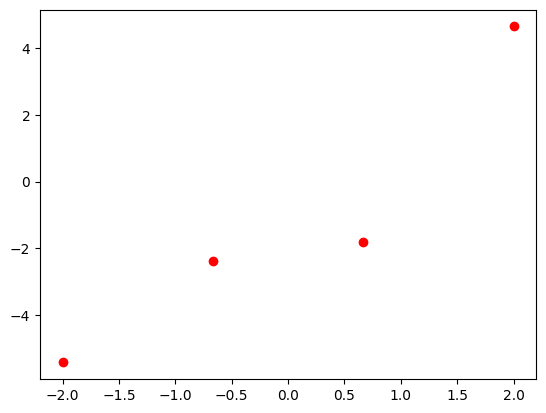

In [18]:
plt.scatter(x, y, c="red")
plt.show()


Modelar $y \sim \mathcal{N}(ax+b, \sigma)$, pero tratando a $a$ y $𝑏$ como distribuciones gaussianas:


* $ax+b$ es la media de la distribución de salida $y$.
*   $a \sim \mathcal{N}(\mu_a, \sigma_a^2)$
*   $b \sim \mathcal{N}(\mu_b, \sigma_b^2)$

Y aprender $\lambda = (\mu_a, \sigma_a^2, \mu_b, \sigma_b^2)$ usando VI.



## Modelar la función de pérdida con Inferencia Variacional

* La idea principal es aprender una distribución para los parámetros del modelo. En el caso de la regresión lineal, se busca aprender una distribución para los parámetros $a$ y $b$ de la regresión.

* Para cada parámetro $a$ y $b$, se supone una **distribución Normal** con parámetros $\mu$ y $\sigma$. Por lo tanto, se tiene que aprender $\mu_a$, $\sigma_a$, $\mu_b$ y $\sigma_b$.

* Como vimos en clases, la **función de pérdida** para inferencia variacional es:

$$
\text{loss}_{\text{VI}} = \text{loss}_{\text{KL}} + \text{loss}_{\text{NLL}}  = \text{KL}[q_{\lambda}(\theta) || p(\theta)] - E_{\theta \sim q_{\lambda}} [\log{p(D|\theta)}]
$$

Al respecto, podemos notar que:

*   $\text{loss}_{\text{KL}}$ tiene solución analítica:
$$\text{loss}_{\text{KL}}=  \text{KL}[q_{\lambda}(\theta)||p(\theta)]  = \text{KL}[N(\mu,\sigma)||N(0,1)] = -\frac{1}{2}(1 + \log{(\sigma^2)} - \mu^2 -\sigma^2 )$$

*   $\text{loss}_{\text{NLL}}$ requiere calcular $E_{\theta \sim q_{\lambda}} [\log{p(D|\theta)}]$, lo que no es tan simple.

*  Se puede aproximar el valor esperado con el promedio empírico promediando sobre $-\log{p(D|\theta)}]$ para diferentes $\theta$, que son muestreados de $\theta \sim q_{\lambda}$. ¿Cuántos muestreos se necesitan? **Solo uno**.



* ¿Por qué solo uno? Queremos minimizar una función de pérdida que depende de muestras de esa distribución.

* El término
$$E_{\theta \sim q_{\lambda}} [\log{p(D|\theta)}$$
 es la esperanza promedio  de la log-verosimilitud sobre todas las posibles configuraciones  de parámetros $\theta = (a,b)$, que vienen de la distribución $q_\lambda$ que se está aprendiendo.

* ¿Cómo estimamos esa esperanza? Se usa **Monte Carlo**: promediamos evaluaciones de la función en diferentes muestras $\theta^{(1)}, \theta^{(2)}, ..., \theta^{(K)}$, tomadas de  $q_\lambda$.

$$
\mathbb{E}_{\theta \sim q_{\lambda}} \left[\log p(D \mid \theta)\right] \approx \frac{1}{K} \sum_{k=1}^{K} \log p(D \mid \theta^{(k)})$$

* En la práctica, para entrenar una red neuronal no necesitas muchas muestras $K$
 * Con que tomes una sola muestra $\theta^{(1)} \sim q_\lambda$ , eso te da una estimación suficientemente buena del gradiente de la pérdida.

 * Es decir, haces una sola pasada con un solo $(a,b)$ para un minibatch de datos, y eso basta para actualizar $\sigma$ con gradientes.
 * En otras palabras, se usa  una única muestra $\theta^{(1)} \sim q_\lambda$ y se calcula  $\log p(D | \theta^{(1)} )$, que no es un buen estimador del promedio, pero sí da un estimador del gradiente que es ruidoso pero no sesgado.
 * Como se entrena con gradient descent, lo que nos interesa es:

 $$\nabla_{\lambda} \, \mathbb{E}_{\theta \sim q_{\lambda}} \left[ \log p(D \mid \theta) \right]$$
 * Y se puede demostrar (con el truco de reparametrización) que este gradiente se puede estimar usando una sola muestra por batch $→$ Aunque esto sea una estimación muy ruidosa, el ruido se cancela cuando haces muchas actualizaciones, y por eso el modelo converge.
 * Lo que hago una vez por batch, lo repito muchas veces a lo largo del entrenamiento, y eso equivale a tirar el dado muchas veces, pero distribuido en el tiempo, no dentro de cada batch.

* Pero también aparece el problema, ya que no se puede derivar directamente a través de una operación de muestreo aleatorio.

* Considerando $N(y_i;a\cdot x_i + b, \sigma)$ como la función de densidad de probabilidad de una distribución Normal, calculamos NLL:
  
$$
E_{\theta \sim q_{\lambda}} \log{p(D|(a,b))}=\sum_{i=1}^{n}\log{(N(y_i;a \cdot x_i + b, \sigma))}
$$

* Como dijimos, para aproxima NLL, se muestrea un solo valor de $a$ y $b$.

* Notar que la derivada de la pérdida con respecto al parámetro $\mu_a$, implica cacular la derivada de la densidad $N(\mu_a, \sigma_a)$ con respecto a $\mu_a$, pero $a$ es un valor muestreado de una Gaussiana, por lo que no se puede porque $a$ es un valor aleatorio y no sabemos en que punto tomar la derivada de una función de densidad Normal.

* La soución es un **reparatmetrization trick**. En vez de muestrear $a\sim N(\mu_a, \sigma_a)$ se calcula $a_{\text{rep}} = \mu_a + \sigma_a \cdot \epsilon $ y se muestrea $\epsilon N(0,1)$ y se puede hacer backpropagation con respecto a $\sigma_a$ y $\mu_a$

* En otras palabras,
  * Se toma una muestra de $\varepsilon \sim \mathcal{N}(0,1)$,
  * y se transforma con $\mu_a$ y $\sigma_a$ para obtener una muestra de $a \sim \mathcal{N}(\mu_a, \sigma_a^2)$,
  * y esta transformación es diferenciable :)

* Finalmente, se quiere minimizar la esperanza de la pérdida (como la log-verosimilitud negativa), y ahora podemos estimar esa esperanza con Monte Carlo (una muestra basta, como ya vimos), y calcular derivadas respecto a los parámetros de la distribución.

In [30]:
class Logger:
    """
    Logger class for logging the weights, gradients, and losses at each step.
    """

    def __init__(self, steps, num_weights = 4):
        self.steps = steps
        self.num_weights = num_weights
        self.X = np.zeros((steps, 12))
        self.header = 'epoch,w0,w1,w2,w3,wg0,wg1,wg2,wg3,loss,loss_kl,loss_mse'

    def log(self, step, epoch, w, w_grad, loss, loss_kl, loss_mse):
        n = self.num_weights
        self.X[step,0] = epoch
        self.X[step,1:(n+1)] = w.numpy()
        self.X[step,(n+1):((2*n)+1)] = w_grad.numpy()
        self.X[step,((2*n)+1)] = loss.numpy()
        self.X[step,((2*n)+2)] = loss_kl.numpy()
        self.X[step,((2*n)+3)] = loss_mse.numpy()

In [31]:
# Configuración de parámetros
epochs = 10000
learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate)
logger = Logger(epochs)

# Vector de parámetros inicial: mu_a, sig_a, mu_b, sig_b
w_0 = (1.0, 1.0, 1.0, 1.0)
w = tf.Variable(w_0)

# Distribución normal para el "truco variacional"
normal_dist = tfp.distributions.Normal(loc=0.0, scale=1.0)

# Bucle de entrenamiento
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # Extracción y transformación de parámetros
        mu_a = w[0]
        sig_a = tf.math.softplus(w[1])  # Debe ser positivo, por eso se usa softplus
        mu_b = w[2]
        sig_b = tf.math.softplus(w[3])  # Debe ser positivo, por eso se usa softplus

        # Solución analítica de la divergencia KL con priors Gaussianos
        kl_divergence = -0.5 * (
            1.0 + tf.math.log(sig_a**2) - sig_a**2 - mu_a**2 +
            1.0 + tf.math.log(sig_b**2) - sig_b**2 - mu_b**2
        )

        # Truco de reparametrización para el muestreo
        sample_a = mu_a + sig_a * normal_dist.sample()
        sample_b = mu_b + sig_b * normal_dist.sample()

        # Distribución normal para y con parámetros muestreados
        y_distribution = tfp.distributions.Normal(loc=x * sample_a + sample_b, scale=sigma)
        negative_log_likelihood = -tf.reduce_sum(y_distribution.log_prob(y.reshape(-1, 1)))

        # Pérdida total
        total_loss = negative_log_likelihood + kl_divergence

    # Cálculo de gradientes y actualización de parámetros
    gradients = tape.gradient(total_loss, w)
    logger.log(epoch, epoch, w, gradients, total_loss, kl_divergence, negative_log_likelihood)
    w.assign_sub(learning_rate * gradients)

    # Registro del progreso cada 2000 épocas y al inicio
    if (epoch + 1) % 2000 == 0 or epoch == 0:
        print(f"Época {epoch + 1}: Pérdida = {total_loss.numpy()}, Tasa de aprendizaje = {learning_rate}")
        print(f"mu_a = {w[0].numpy()}, mu_b = {w[2].numpy()}")


Época 1: Pérdida = 60.468772888183594, Tasa de aprendizaje = 0.001
mu_a = 1.0289522409439087, mu_b = 0.9950301647186279
Época 2000: Pérdida = 12.024393081665039, Tasa de aprendizaje = 0.001
mu_a = 2.0599944591522217, mu_b = -0.9706847071647644
Época 4000: Pérdida = 10.89224910736084, Tasa de aprendizaje = 0.001
mu_a = 2.0720646381378174, mu_b = -1.008079171180725
Época 6000: Pérdida = 10.727089881896973, Tasa de aprendizaje = 0.001
mu_a = 2.0853185653686523, mu_b = -1.0189764499664307
Época 8000: Pérdida = 12.21993637084961, Tasa de aprendizaje = 0.001
mu_a = 2.0496082305908203, mu_b = -0.9774420261383057
Época 10000: Pérdida = 12.340986251831055, Tasa de aprendizaje = 0.001
mu_a = 2.0510733127593994, mu_b = -1.020429015159607


In [32]:
a_0 = tf.math.softplus(w[0]).numpy()
a_1 = tf.math.softplus(w[1]).numpy()
b_2 = w[2].numpy()
b_3 = tf.math.softplus(w[3]).numpy()

print(f"a = {a_0} {a_1} b = {b_2} {b_3}")

a = 2.172048330307007 0.3168787658214569 b = -1.020429015159607 0.44447875022888184


In [22]:
loss_history, loss_history_nll, loss_history_kl = logger.X[:, 9], logger.X[:, 10], logger.X[:, 11]

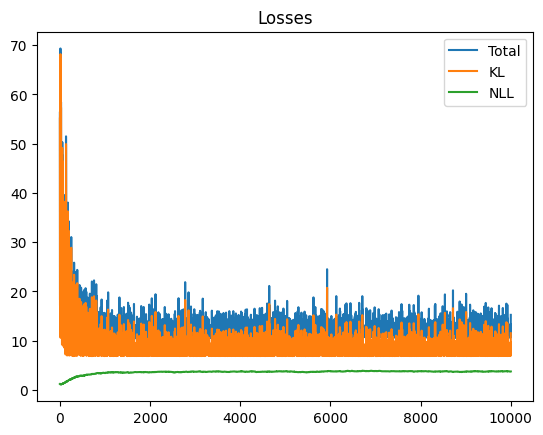

In [23]:
plt.plot(loss_history, label="Total")
plt.plot(loss_history_kl, label="KL")
plt.plot(loss_history_nll, label="NLL")
plt.legend()
plt.title("Losses")
plt.show()

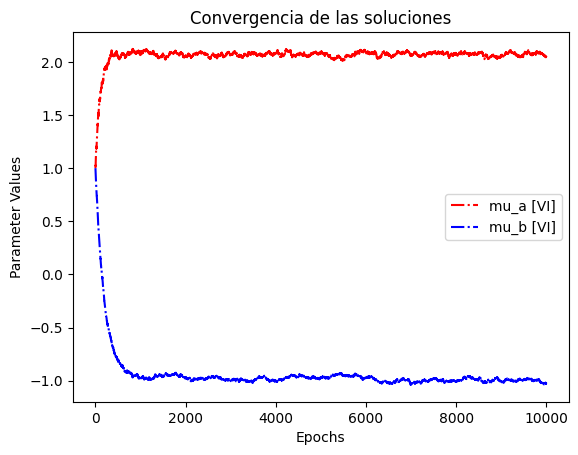

In [24]:
W = logger.X
weights = W[:,1:5]
epochs = W.shape[0]

plt.plot(weights[:,0],color='r',linestyle='-.')
plt.plot(weights[:,2],color='b', linestyle='-.')

plt.xlabel('Epochs')
plt.ylabel('Parameter Values')
plt.legend(('mu_a [VI]', 'mu_b [VI]'))
plt.title('Convergencia de las soluciones')
plt.show()

## Bayesian Neural Network (BNN)

In [25]:
def negative_log_likelihood(targets, predicted_distribution):
    return -predicted_distribution.log_prob(targets)

def create_normal_distribution(mean):
    return tfp.distributions.Normal(loc=mean[:, 0:1], scale=sigma)

def kl_divergence(q_distribution, p_distribution, _):
    return tfp.distributions.kl_divergence(q_distribution, p_distribution) / (n * 1.0)

model = tf.keras.Sequential([

    tfp.layers.DenseReparameterization(
        units=1,
        kernel_divergence_fn=kl_divergence,
        bias_divergence_fn=kl_divergence,
        bias_prior_fn=tfp.layers.util.default_multivariate_normal_fn,
        bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn()
    ),
    tfp.layers.DistributionLambda(create_normal_distribution)
])


sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
model.compile(loss=negative_log_likelihood, optimizer=sgd_optimizer)

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_probability.python.layers.dense_variational.DenseReparameterization object at 0x7898da4d6d50> (of type <class 'tensorflow_probability.python.layers.dense_variational.DenseReparameterization'>)

In [ ]:
hist = model.fit(x, y, epochs=5000, batch_size=n, verbose=False)
plt.plot(hist.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Total loss')

## Comparación de resultados

In [ ]:
def softplus_squared(x):
    return np.log(1 + np.exp(x))**2

Los parámetros aprendidos por la regresión lineal son los siguientes:

In [ ]:
_w = w.numpy()
_w[0], softplus_squared(_w[1]), _w[2], softplus_squared(_w[3])

(2.0439196, 0.10144689197849237, -0.99211365, 0.19587144961548983)

Los parámetros aprendidos por la BNN son los siguientes:

In [ ]:
model_weights = model.get_weights()

In [ ]:
model_weights[0][0,0], softplus_squared(model_weights[1][[0]])[0,0], model_weights[2][0], softplus_squared(model_weights[3][[0]])[0]

(2.0678554, 0.108449474, -0.9716571, 0.19621685)